
<a id='kalman'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# A First Look at the Kalman Filter


<a id='index-0'></a>

## Contents

- [A First Look at the Kalman Filter](#A-First-Look-at-the-Kalman-Filter)  
  - [Overview](#Overview)  
  - [The Basic Idea](#The-Basic-Idea)  
  - [Convergence](#Convergence)  
  - [Implementation](#Implementation)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

In addition to what’s in Anaconda, this lecture will need the following libraries

In [1]:
!pip install quantecon

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Overview

This lecture provides a simple and intuitive introduction to the Kalman filter, for those who either

- have heard of the Kalman filter but don’t know how it works, or  
- know the Kalman filter equations, but don’t know where they come from  


For additional (more advanced) reading on the Kalman filter, see

- [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), section 2.7  
- [[AM05]](https://lectures.quantecon.org/py/zreferences.html#andersonmoore2005)  


The second reference presents a  comprehensive treatment of the Kalman filter

Required knowledge: Familiarity with matrix manipulations, multivariate normal distributions, covariance matrices, etc.

## The Basic Idea

The Kalman filter has many applications in economics, but for now
let’s pretend that we are rocket scientists

A missile has been launched from country Y and our mission is to track it

Let $ x  \in \mathbb{R}^2 $ denote the current location of the missile—a
pair indicating latitude-longitute coordinates on a map

At the present moment in time, the precise location $ x $ is unknown, but
we do have some beliefs about $ x $

One way to summarize our knowledge is a point prediction $ \hat x $

- But what if the President wants to know the probability that the missile is currently over the Sea of Japan?  
- Then it is better to summarize our initial beliefs with a bivariate probability density $ p $  
  
  - $ \int_E p(x)dx $ indicates the probability that we attach to the missile being in region $ E $  
  


The density $ p $ is called our *prior* for the random variable $ x $

To keep things tractable in our example,  we  assume that our prior is Gaussian

In particular, we take


<a id='equation-prior'></a>
$$
p = N(\hat x, \Sigma) \tag{1}
$$

where $ \hat x $ is the mean of the distribution and $ \Sigma $ is a
$ 2 \times 2 $ covariance matrix.  In our simulations, we will suppose that


<a id='equation-kalman-dhxs'></a>
$$
\hat x
= \left(
\begin{array}{c}
    0.2 \\
    -0.2
\end{array}
  \right),
\qquad
\Sigma
= \left(
\begin{array}{cc}
    0.4 & 0.3 \\
    0.3 & 0.45
\end{array}
  \right) \tag{2}
$$

This density $ p(x) $ is shown below as a contour map, with the center of the red ellipse being equal to $ \hat x $

/home/quantecon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.


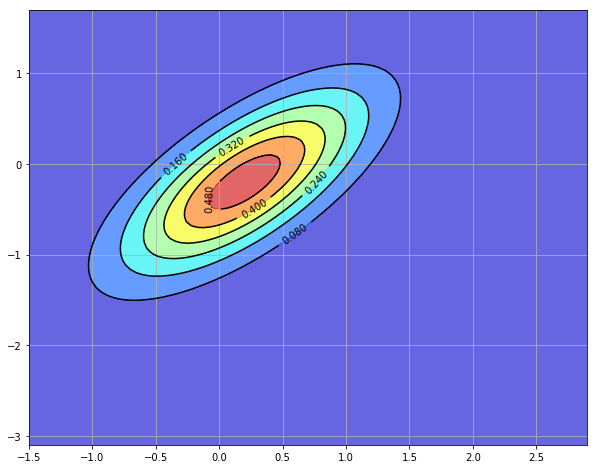

In [2]:
from scipy import linalg
import numpy as np
import matplotlib.cm as cm
from matplotlib.mlab import bivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

# == Set up the Gaussian prior density p == #
Σ = [[0.4, 0.3], [0.3, 0.45]]
Σ = np.matrix(Σ)
x_hat = np.matrix([0.2, -0.2]).T
# == Define the matrices G and R from the equation y = G x + N(0, R) == #
G = [[1, 0], [0, 1]]
G = np.matrix(G)
R = 0.5 * Σ
# == The matrices A and Q == #
A = [[1.2, 0], [0, -0.2]]
A = np.matrix(A)
Q = 0.3 * Σ
# == The observed value of y == #
y = np.matrix([2.3, -1.9]).T

# == Set up grid for plotting == #
x_grid = np.linspace(-1.5, 2.9, 100)
y_grid = np.linspace(-3.1, 1.7, 100)
X, Y = np.meshgrid(x_grid, y_grid)


def gen_gaussian_plot_vals(μ, C):
    "Z values for plotting the bivariate Gaussian N(μ, C)"
    m_x, m_y = float(μ[0]), float(μ[1])
    s_x, s_y = np.sqrt(C[0, 0]), np.sqrt(C[1, 1])
    s_xy = C[0, 1]
    return bivariate_normal(X, Y, s_x, s_y, m_x, m_y, s_xy)

# Plot the figure

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)

plt.show()

### The Filtering Step

We are now presented with some good news and some bad news

The good news is that the missile has been located by our sensors, which report that the current location is $ y = (2.3, -1.9) $

The next figure shows the original prior $ p(x) $ and the new reported
location $ y $

/home/quantecon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.


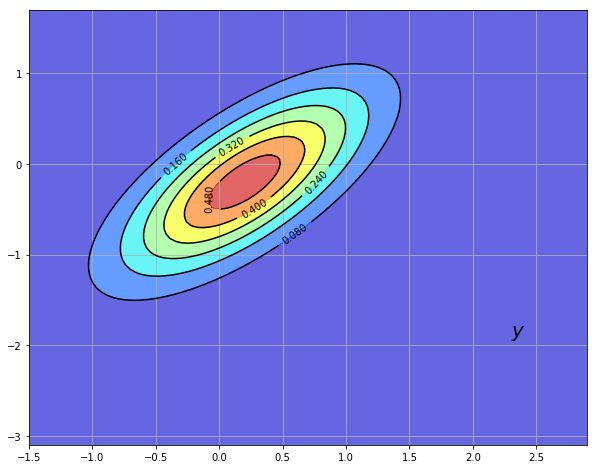

In [3]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

The bad news is that our sensors are imprecise

In particular, we should interpret the output of our sensor not as
$ y=x $, but rather as


<a id='equation-kl-measurement-model'></a>
$$
y = G x + v, \quad \text{where} \quad v \sim N(0, R) \tag{3}
$$

Here $ G $ and $ R $ are $ 2 \times 2 $ matrices with $ R $
positive definite.  Both are assumed known, and the noise term $ v $ is assumed
to be independent of $ x $

How then should we combine our prior $ p(x) = N(\hat x, \Sigma) $ and this
new information $ y $ to improve our understanding of the location of the
missile?

As you may have guessed, the answer is to use Bayes’ theorem, which tells
us to  update our prior $ p(x) $ to $ p(x \,|\, y) $ via

$$
p(x \,|\, y) = \frac{p(y \,|\, x) \, p(x)} {p(y)}
$$

where $ p(y) = \int p(y \,|\, x) \, p(x) dx $

In solving for $ p(x \,|\, y) $, we observe that

- $ p(x) = N(\hat x, \Sigma) $  
- In view of [(3)](#equation-kl-measurement-model), the conditional density $ p(y \,|\, x) $ is $ N(Gx, R) $  
- $ p(y) $ does not depend on $ x $, and enters into the calculations only as a normalizing constant  


Because we are in a linear and Gaussian framework, the updated density can be computed by calculating population linear regressions

In particular, the solution is known <sup><a href=#f1 id=f1-link>[1]</a></sup> to be

$$
p(x \,|\, y) = N(\hat x^F, \Sigma^F)
$$

where


<a id='equation-kl-filter-exp'></a>
$$
\hat x^F := \hat x + \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
\quad \text{and} \quad
\Sigma^F := \Sigma - \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma \tag{4}
$$

Here  $ \Sigma G' (G \Sigma G' + R)^{-1} $ is the matrix of population regression coefficients of the hidden object $ x - \hat x $ on the surprise $ y - G \hat x $

This new density $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ is shown in the next figure via contour lines and the color map

The original density is left in as contour lines for comparison

/home/quantecon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.


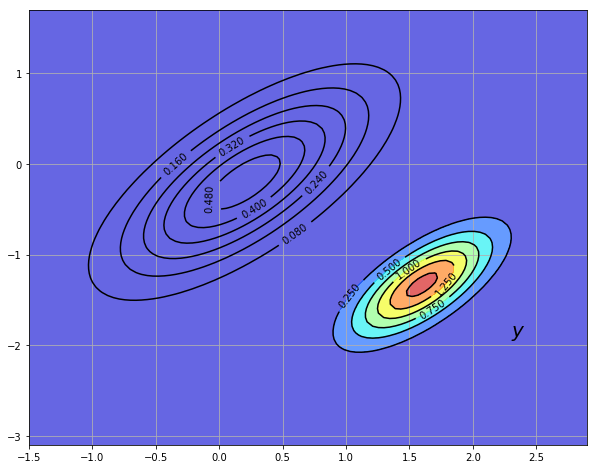

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
new_Z = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

Our new density twists the prior $ p(x) $ in a direction determined by  the new
information $ y - G \hat x $

In generating the figure, we set $ G $ to the identity matrix and $ R = 0.5 \Sigma $ for $ \Sigma $ defined in [(2)](#equation-kalman-dhxs)


<a id='kl-forecase-step'></a>

### The Forecast Step

What have we achieved so far?

We have obtained probabilities for the current location of the state (missile) given prior and current information

This is called “filtering” rather than forecasting, because we are filtering
out noise rather than looking into the future

- $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ is called the *filtering distribution*  


But now let’s suppose that we are given another task: to predict the location of the missile after one unit of time (whatever that may be) has elapsed

To do this we need a model of how the state evolves

Let’s suppose that we have one, and that it’s linear and Gaussian. In particular,


<a id='equation-kl-xdynam'></a>
$$
x_{t+1} = A x_t + w_{t+1}, \quad \text{where} \quad w_t \sim N(0, Q) \tag{5}
$$

Our aim is to combine this law of motion and our current distribution $ p(x \,|\, y) = N(\hat x^F, \Sigma^F) $ to come up with a new *predictive* distribution for the location in one unit of time

In view of [(5)](#equation-kl-xdynam), all we have to do is introduce a random vector $ x^F \sim N(\hat x^F, \Sigma^F) $ and work out the distribution of $ A x^F + w $ where $ w $ is independent of $ x^F $ and has distribution $ N(0, Q) $

Since linear combinations of Gaussians are Gaussian, $ A x^F + w $ is Gaussian

Elementary calculations and the expressions in [(4)](#equation-kl-filter-exp) tell us that

$$
\mathbb{E} [A x^F + w]
= A \mathbb{E} x^F + \mathbb{E} w
= A \hat x^F
= A \hat x + A \Sigma G' (G \Sigma G' + R)^{-1}(y - G \hat x)
$$

and

$$
\operatorname{Var} [A x^F + w]
= A \operatorname{Var}[x^F] A' + Q
= A \Sigma^F A' + Q
= A \Sigma A' - A \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma A' + Q
$$

The matrix $ A \Sigma G' (G \Sigma G' + R)^{-1} $ is often written as
$ K_{\Sigma} $ and called the *Kalman gain*

- The subscript $ \Sigma $ has been added to remind us that  $ K_{\Sigma} $ depends on $ \Sigma $, but not $ y $ or $ \hat x $  


Using this notation, we can summarize our results as follows

Our updated prediction is the density $ N(\hat x_{new}, \Sigma_{new}) $ where


<a id='equation-kl-mlom0'></a>
$$
\begin{aligned}
    \hat x_{new} &:= A \hat x + K_{\Sigma} (y - G \hat x) \\
    \Sigma_{new} &:= A \Sigma A' - K_{\Sigma} G \Sigma A' + Q \nonumber
\end{aligned} \tag{6}
$$

- The density $ p_{new}(x) = N(\hat x_{new}, \Sigma_{new}) $ is called the *predictive distribution*  


The predictive distribution is the new density shown in the following figure, where
the update has used parameters

$$
A
= \left(
\begin{array}{cc}
    1.2 & 0.0 \\
    0.0 & -0.2
\end{array}
  \right),
  \qquad
Q = 0.3 * \Sigma
$$

/home/quantecon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.


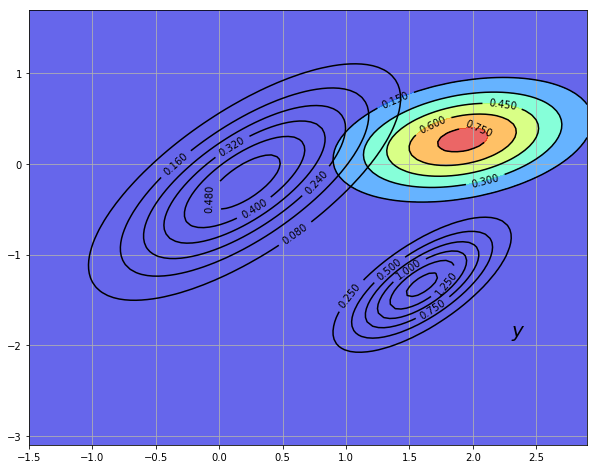

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

### The Recursive Procedure


<a id='index-1'></a>
Let’s look back at what we’ve done

We started the current period with a prior $ p(x) $ for the location $ x $ of the missile

We then used the current measurement $ y $ to update to $ p(x \,|\, y) $

Finally, we used the law of motion [(5)](#equation-kl-xdynam) for $ \{x_t\} $ to update to $ p_{new}(x) $

If we now step into the next period, we are ready to go round again, taking $ p_{new}(x) $
as the current prior

Swapping notation $ p_t(x) $ for $ p(x) $ and $ p_{t+1}(x) $ for $ p_{new}(x) $, the full recursive procedure is:

1. Start the current period with prior $ p_t(x) = N(\hat x_t, \Sigma_t) $  
1. Observe current measurement $ y_t $  
1. Compute the filtering distribution $ p_t(x \,|\, y) = N(\hat x_t^F, \Sigma_t^F) $ from $ p_t(x) $ and $ y_t $, applying Bayes rule and the conditional distribution [(3)](#equation-kl-measurement-model)  
1. Compute the predictive distribution $ p_{t+1}(x) = N(\hat x_{t+1}, \Sigma_{t+1}) $ from the filtering distribution and [(5)](#equation-kl-xdynam)  
1. Increment $ t $ by one and go to step 1  


Repeating [(6)](#equation-kl-mlom0), the dynamics for $ \hat x_t $ and $ \Sigma_t $ are as follows


<a id='equation-kalman-lom'></a>
$$
\begin{aligned}
    \hat x_{t+1} &= A \hat x_t + K_{\Sigma_t} (y_t - G \hat x_t) \\
    \Sigma_{t+1} &= A \Sigma_t A' - K_{\Sigma_t} G \Sigma_t A' + Q \nonumber
\end{aligned} \tag{7}
$$

These are the standard dynamic equations for the Kalman filter (see, for example, [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), page 58)


<a id='kalman-convergence'></a>

## Convergence

The matrix $ \Sigma_t $ is a measure of the uncertainty of our prediction $ \hat x_t $ of $ x_t $

Apart from special cases, this uncertainty will never be fully resolved, regardless of how much time elapses

One reason is that our prediction $ \hat x_t $ is made based on information available at $ t-1 $, not $ t $

Even if we know the precise value of $ x_{t-1} $ (which we don’t), the transition equation [(5)](#equation-kl-xdynam) implies that $ x_t = A x_{t-1} + w_t $

Since the shock $ w_t $ is not observable at $ t-1 $, any time $ t-1 $ prediction of $ x_t $ will incur some error (unless $ w_t $ is degenerate)

However, it is certainly possible that $ \Sigma_t $ converges to a constant matrix as $ t \to \infty $

To study this topic, let’s expand the second equation in [(7)](#equation-kalman-lom):


<a id='equation-kalman-sdy'></a>
$$
\Sigma_{t+1} = A \Sigma_t A' -  A \Sigma_t G' (G \Sigma_t G' + R)^{-1} G \Sigma_t A' + Q \tag{8}
$$

This is a nonlinear difference equation in $ \Sigma_t $

A fixed point of [(8)](#equation-kalman-sdy) is a constant matrix $ \Sigma $ such that


<a id='equation-kalman-dare'></a>
$$
\Sigma = A \Sigma A' -  A \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma A' + Q \tag{9}
$$

Equation [(8)](#equation-kalman-sdy) is known as a discrete time Riccati difference equation

Equation [(9)](#equation-kalman-dare) is known as a [discrete time algebraic Riccati equation](https://en.wikipedia.org/wiki/Algebraic_Riccati_equation)

Conditions under which a fixed point exists and the sequence $ \{\Sigma_t\} $ converges to it are discussed in [[AHMS96]](https://lectures.quantecon.org/py/zreferences.html#ahms1996) and [[AM05]](https://lectures.quantecon.org/py/zreferences.html#andersonmoore2005), chapter 4

A sufficient (but not necessary) condition is that all the eigenvalues $ \lambda_i $ of $ A $ satisfy $ |\lambda_i| < 1 $ (cf. e.g., [[AM05]](https://lectures.quantecon.org/py/zreferences.html#andersonmoore2005), p. 77)

(This strong condition assures that the unconditional  distribution of $ x_t $  converges as $ t \rightarrow + \infty $)

In this case, for any initial choice of $ \Sigma_0 $ that is both nonnegative and symmetric, the sequence $ \{\Sigma_t\} $ in [(8)](#equation-kalman-sdy) converges to a nonnegative symmetric matrix $ \Sigma $ that solves [(9)](#equation-kalman-dare)

## Implementation


<a id='index-2'></a>
The class `Kalman` from the [QuantEcon.py](http://quantecon.org/python_index.html) package implements the Kalman filter

- Instance data consists of:  
  
  - the moments $ (\hat x_t, \Sigma_t) $ of the current prior  
  - An instance of the [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class from [QuantEcon.py](http://quantecon.org/python_index.html)  
  


The latter represents a linear state space model of the form

$$
\begin{aligned}
    x_{t+1} & = A x_t + C w_{t+1}
    \\
    y_t & = G x_t + H v_t
\end{aligned}
$$

where the shocks $ w_t $ and $ v_t $ are iid standard normals

To connect this with the notation of this lecture we set

$$
Q := CC' \quad \text{and} \quad R := HH'
$$

- The class `Kalman` from the [QuantEcon.py](http://quantecon.org/python_index.html) package has a number of methods, some that we will wait to use until we study more advanced applications in subsequent lectures  
- Methods pertinent for this lecture  are:  
  
  - `prior_to_filtered`, which updates $ (\hat x_t, \Sigma_t) $ to $ (\hat x_t^F, \Sigma_t^F) $  
  - `filtered_to_forecast`, which updates the filtering distribution to the predictive distribution – which becomes the new prior $ (\hat x_{t+1}, \Sigma_{t+1}) $  
  - `update`, which combines the last two methods  
  - a `stationary_values`, which computes the solution to [(9)](#equation-kalman-dare) and the corresponding (stationary) Kalman gain  
  


You can view the program [on GitHub](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/kalman.py)

## Exercises


<a id='kalman-ex1'></a>

### Exercise 1

Consider the following simple application of the Kalman filter, loosely based
on [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), section 2.9.2

Suppose that

- all variables are scalars  
- the hidden state $ \{x_t\} $ is in fact constant, equal to some $ \theta \in \mathbb{R} $ unknown to the modeler  


State dynamics are therefore given by [(5)](#equation-kl-xdynam) with $ A=1 $, $ Q=0 $ and $ x_0 = \theta $

The measurement equation is $ y_t = \theta + v_t $ where $ v_t $ is $ N(0,1) $ and iid

The task of this exercise to simulate the model and, using the code from `kalman.py`, plot the first five predictive densities $ p_t(x) = N(\hat x_t, \Sigma_t) $

As shown in [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), sections 2.9.1–2.9.2, these distributions asymptotically put all mass on the unknown value $ \theta $

In the simulation, take $ \theta = 10 $, $ \hat x_0 = 8 $ and $ \Sigma_0 = 1 $

Your figure should – modulo randomness – look something like this

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/kl_ex1_fig.png" style="width:100%;height:100%">

  

<a id='kalman-ex2'></a>

### Exercise 2

The preceding figure gives some support to the idea that probability mass
converges to $ \theta $

To get a better idea, choose a small $ \epsilon > 0 $ and calculate

$$
z_t := 1 - \int_{\theta - \epsilon}^{\theta + \epsilon} p_t(x) dx
$$

for $ t = 0, 1, 2, \ldots, T $

Plot $ z_t $ against $ T $, setting $ \epsilon = 0.1 $ and $ T = 600 $

Your figure should show error erratically declining something like this

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/kl_ex2_fig.png" style="width:100%;height:100%">

  

<a id='kalman-ex3'></a>

### Exercise 3

As discussed [above](#kalman-convergence), if the shock sequence $ \{w_t\} $ is not degenerate, then it is not in general possible to predict $ x_t $ without error at time $ t-1 $ (and this would be the case even if we could observe $ x_{t-1} $)

Let’s now compare the prediction $ \hat x_t $ made by the Kalman filter
against a competitor who **is** allowed to observe $ x_{t-1} $

This competitor will use the conditional expectation $ \mathbb E[ x_t
\,|\, x_{t-1}] $, which in this case is $ A x_{t-1} $

The conditional expectation is known to be the optimal prediction method in terms of minimizing mean squared error

(More precisely, the minimizer of $ \mathbb E \, \| x_t - g(x_{t-1}) \|^2 $ with respect to $ g $ is $ g^*(x_{t-1}) := \mathbb E[ x_t \,|\, x_{t-1}] $)

Thus we are comparing the Kalman filter against a competitor who has more
information (in the sense of being able to observe the latent state) and
behaves optimally in terms of minimizing squared error

Our horse race will be assessed in terms of squared error

In particular, your task is to generate a graph plotting observations of both $ \| x_t - A x_{t-1} \|^2 $ and $ \| x_t - \hat x_t \|^2 $ against $ t $ for $ t = 1, \ldots, 50 $

For the parameters, set $ G = I, R = 0.5 I $ and $ Q = 0.3 I $, where $ I $ is
the $ 2 \times 2 $ identity

Set

$$
A
= \left(
\begin{array}{cc}
    0.5 & 0.4 \\
    0.6 & 0.3
\end{array}
  \right)
$$

To initialize the prior density, set

$$
\Sigma_0
= \left(
\begin{array}{cc}
    0.9 & 0.3 \\
    0.3 & 0.9
\end{array}
  \right)
$$

and $ \hat x_0 = (8, 8) $

Finally, set $ x_0 = (0, 0) $

You should end up with a figure similar to the following (modulo randomness)

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/kalman_ex3.png" style="width:100%;height:100%">

  
Observe how, after an initial learning period, the Kalman filter performs quite well, even relative to the competitor who predicts optimally with knowledge of the latent state


<a id='kalman-ex4'></a>

### Exercise 4

Try varying the coefficient $ 0.3 $ in $ Q = 0.3 I $ up and down

Observe how the diagonal values in the stationary solution $ \Sigma $ (see [(9)](#equation-kalman-dare)) increase and decrease in line with this coefficient

The interpretation is that more randomness in the law of motion for $ x_t $ causes more (permanent) uncertainty in prediction

## Solutions

In [6]:
from quantecon import Kalman
from quantecon import LinearStateSpace
from scipy.stats import norm

### Exercise 1

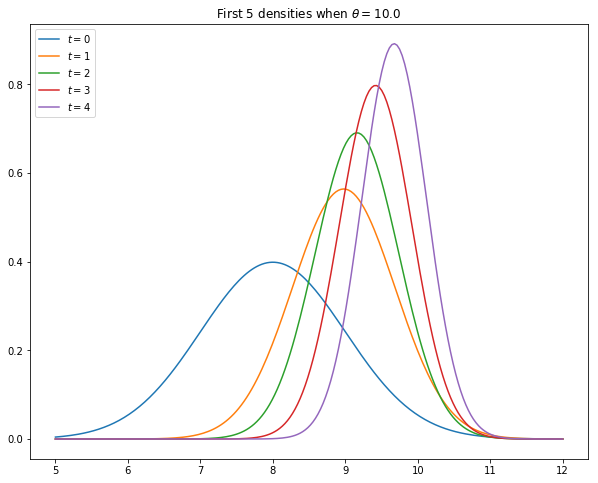

In [7]:
# == parameters == #
θ = 10  # Constant value of state x_t
A, C, G, H = 1, 0, 1, 1
ss = LinearStateSpace(A, C, G, H, mu_0=θ)

# == set prior, initialize kalman filter == #
x_hat_0, Σ_0 = 8, 1
kalman = Kalman(ss, x_hat_0, Σ_0)

# == draw observations of y from state space model == #
N = 5
x, y = ss.simulate(N)
y = y.flatten()

# == set up plot == #
fig, ax = plt.subplots(figsize=(10,8))
xgrid = np.linspace(θ - 5, θ + 2, 200)

for i in range(N):
    # == record the current predicted mean and variance == #
    m, v = [float(z) for z in (kalman.x_hat, kalman.Sigma)]
    # == plot, update filter == #
    ax.plot(xgrid, norm.pdf(xgrid, loc=m, scale=np.sqrt(v)), label=f'$t={i}$')
    kalman.update(y[i])

ax.set_title(f'First {N} densities when $\\theta = {θ:.1f}$')
ax.legend(loc='upper left')
plt.show()

### Exercise 2

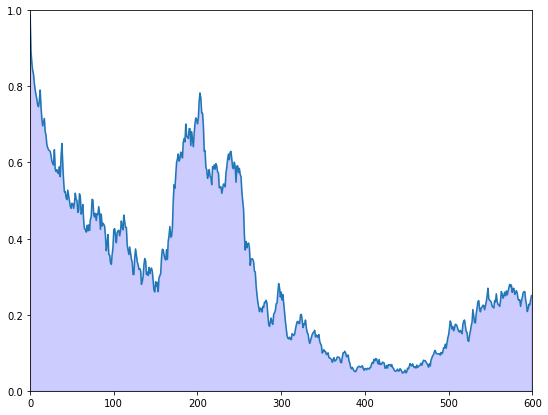

In [8]:
from scipy.integrate import quad

ϵ = 0.1
θ = 10  # Constant value of state x_t
A, C, G, H = 1, 0, 1, 1
ss = LinearStateSpace(A, C, G, H, mu_0=θ)

x_hat_0, Σ_0 = 8, 1
kalman = Kalman(ss, x_hat_0, Σ_0)

T = 600
z = np.empty(T)
x, y = ss.simulate(T)
y = y.flatten()

for t in range(T):
    # Record the current predicted mean and variance, and plot their densities
    m, v = [float(temp) for temp in (kalman.x_hat, kalman.Sigma)]

    f = lambda x: norm.pdf(x, loc=m, scale=np.sqrt(v))
    integral, error = quad(f, θ - ϵ, θ + ϵ)
    z[t] = 1 - integral

    kalman.update(y[t])

fig, ax = plt.subplots(figsize=(9, 7))
ax.set_ylim(0, 1)
ax.set_xlim(0, T)
ax.plot(range(T), z)
ax.fill_between(range(T), np.zeros(T), z, color="blue", alpha=0.2)
plt.show()

### Exercise 3

Eigenvalues of A:
[ 0.9+0.j -0.1+0.j]
Stationary prediction error variance:
[[0.40329108 0.1050718 ]
 [0.1050718  0.41061709]]


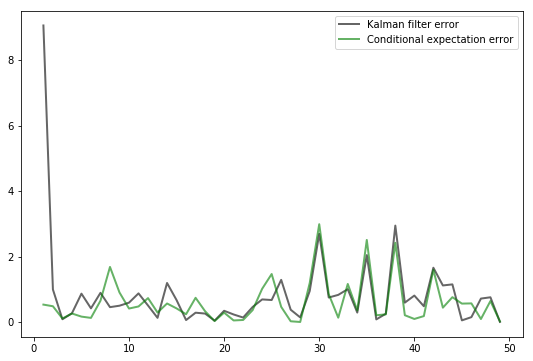

In [9]:
from numpy.random import multivariate_normal
from scipy.linalg import eigvals


# === Define A, C, G, H === #
G = np.identity(2)
H = np.sqrt(0.5) * np.identity(2)

A = [[0.5, 0.4],
     [0.6, 0.3]]
C = np.sqrt(0.3) * np.identity(2)

# === Set up state space mode, initial value x_0 set to zero === #
ss = LinearStateSpace(A, C, G, H, mu_0 = np.zeros(2))

# === Define the prior density === #
Σ = [[0.9, 0.3],
     [0.3, 0.9]]
Σ = np.array(Σ)
x_hat = np.array([8, 8])

# === Initialize the Kalman filter === #
kn = Kalman(ss, x_hat, Σ)

# == Print eigenvalues of A == #
print("Eigenvalues of A:")
print(eigvals(A))

# == Print stationary Σ == #
S, K = kn.stationary_values()
print("Stationary prediction error variance:")
print(S)

# === Generate the plot === #
T = 50
x, y = ss.simulate(T)

e1 = np.empty(T-1)
e2 = np.empty(T-1)

for t in range(1, T):
    kn.update(y[:,t])
    e1[t-1] = np.sum((x[:, t] - kn.x_hat.flatten())**2)
    e2[t-1] = np.sum((x[:, t] - A @ x[:, t-1])**2)

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(range(1, T), e1, 'k-', lw=2, alpha=0.6, label='Kalman filter error')
ax.plot(range(1, T), e2, 'g-', lw=2, alpha=0.6, label='Conditional expectation error')
ax.legend()
plt.show()

**Footnotes**

<p><a id=f1 href=#f1-link><strong>[1]</strong></a> See, for example, page 93 of [[Bis06]](https://lectures.quantecon.org/py/zreferences.html#bishop2006). To get from his expressions to the ones used above, you will also need to apply the [Woodbury matrix identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity).